In [1]:
pip install tensorflow librosa scikit-learn matplotlib numpy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/RAVDESS Emotional speech audio"


In [4]:
# Preprocessing – Feature Extraction with MFCCs
def extract_features(file_path, max_pad_len=174):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

def load_data(data_path):
    X, y = [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".wav"):
                emotion = int(file.split("-")[2]) - 1
                feature = extract_features(os.path.join(root, file))
                X.append(feature)
                y.append(emotion)
    return np.array(X), np.array(y)

# Load data
X, y = load_data(DATA_PATH)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

# Add channel dimension for GRU compatibility
X = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
import numpy as np

# Reshape the input to fit the GRU layer's requirements
X_train = X_train.reshape(X_train.shape[0], 174, 40)
X_test = X_test.reshape(X_test.shape[0], 174, 40)

# Define the GRU model
def build_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(GRU(units, input_shape=(174, 40), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
units = 128  # Number of GRU units
dropout_rate = 0.3  # Dropout rate for regularization
epochs = 50
batch_size = 32

# Build and compile the GRU model
model = build_gru_model(units, dropout_rate)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 174, 128)            │          65,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 174, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 174, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 22272)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,425,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,491,784 (5.69 MB)

 Trainable params: 1,491,528 (5.69 MB)

 Non-trainable params: 256 (1.00 KB)

In [7]:
# Train the GRU model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.2594 - loss: 2.3064 - val_accuracy: 0.4479 - val_loss: 1.4447
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.5080 - loss: 1.2536 - val_accuracy: 0.6250 - val_loss: 1.0249
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.6396 - loss: 0.9641 - val_accuracy: 0.7135 - val_loss: 0.7957
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7443 - loss: 0.6342 - val_accuracy: 0.7986 - val_loss: 0.5506
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.8029 - loss: 0.4967 - val_accuracy: 0.8160 - val_loss: 0.4951
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.8482 - loss: 0.3990 - val_accuracy: 0.8663 - val_loss: 0.3990
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8562 - loss: 0.3704 - val_accuracy: 0.8872 - val_loss: 0.3305
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.8867 - loss: 0.2917 - val_accu

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Predict and generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9050 - loss: 0.6013
Test Accuracy: 0.8958333134651184
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        43
           1       0.93      0.85      0.89        66
           2       0.87      0.94      0.91        71
           3       0.85      0.81      0.83        86
           4       0.95      0.98      0.96        81
           5       0.79      0.94      0.86        72
           6       0.97      0.97      0.97        71
           7       0.92      0.84      0.88        86

    accuracy                           0.90       576
   macro avg       0.90      0.89      0.89       576
weighted avg       0.90      0.90      0.90       576

Confusion Matrix:
 [[35  2  2  4  0  0  0  0]
 [ 4 56  2  0  0  4  0  0]
 [ 0  0 67  0  0  4  0  0]
 [ 0  2  4 70  2  0  2  6]
 [ 0  0  0  2 79  0  0  0]
 [ 0  0  0  4  0 68  0 

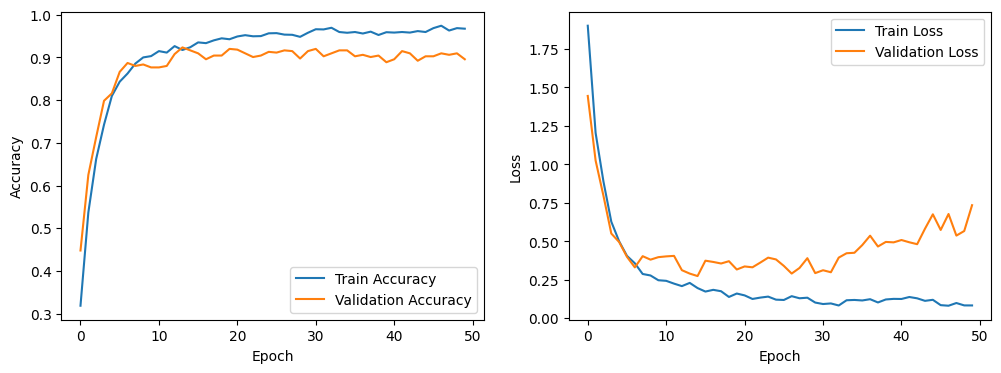

In [9]:
#plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [10]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Flatten, Input

# Reshape the input for GRU compatibility: (batch_size, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 174, 40)
X_test = X_test.reshape(X_test.shape[0], 174, 40)

def model_builder(hp):
    units = hp.Int('units', min_value=64, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    model = Sequential()
    model.add(Input(shape=(174, 40)))  # Corrected input shape
    model.add(GRU(units, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning',
    project_name='gru_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Model Test Accuracy: {test_accuracy}')



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |192               |units
0.2               |0.2               |dropout_rate

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 402ms/step - accuracy: 0.2419 - loss: 2.3637 - val_accuracy: 0.4253 - val_loss: 1.5330
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.5157 - loss: 1.2972 - val_accuracy: 0.6354 - val_loss: 1.0503
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.6448 - loss: 0.9189 - val_accuracy: 0.7344 - val_loss: 0.8171
Epoch 4/10
40/72 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.7191 - loss: 0.7167